# bag-of-words + tf-idf  LogisticRegression

In [21]:
import pandas as pd
import numpy as np
import matplotlib as plt
df = pd.read_csv('cnnchile_7000.csv')
df.head()
df = df.drop(['country','media_outlet','url','date'], 1)
df1 = pd.DataFrame({'full text':df['title']+" "+df['text'],'category':df["category"]})

In [22]:
import spacy

nlp = spacy.load('es_core_news_sm')

from sklearn.feature_extraction.text import CountVectorizer

def feature_extraction(text):
    
    mytokens = nlp(text)

    #Guardamos las palabras como características si corresponden a ciertas categorias gramaticales
    mytokens = [ word for word in mytokens if word.pos_ in ["NOUN", "ADJ", "VERB"] ]
    
    #Transformamos las palabras en minusculas
    mytokens = [ word.lemma_.lower().strip() for word in mytokens ]
    
    # return preprocessed list of tokens
    return mytokens

## bag-of-words + tf-idf

- mejorar el modelo bag-of-words tomando en cuenta el nivel pragmático del lenguaje --> *"Lo que es poco frecuente, es más importante/relevante"*

La desición de usar en todas las pruebas es para darle más importancia a las palabras que se usan en un contexto en especifico, poco frecuentes. Por ejemplo cuando se señale a un país extrangero, o salga el nombre de algun deporte, etc.. pueda guiarse por medios de estas palabras de la decición final.

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

bow_vector = TfidfVectorizer(tokenizer = feature_extraction, min_df=0., max_df=1.0)

In [24]:
from pandas import DataFrame
from sklearn.feature_extraction.text import TfidfVectorizer

bow_vector.fit_transform(df1["full text"].values.astype('U'))

<7000x24927 sparse matrix of type '<class 'numpy.float64'>'
	with 423003 stored elements in Compressed Sparse Row format>

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = df1['full text'].astype('U') 
ylabels = df1['category'].astype('U')
lb = LabelEncoder()
ylabels_encoded = lb.fit_transform(ylabels)
X_train, X_test, y_train, y_test = train_test_split(X, ylabels_encoded, test_size=0.5)

## Logistic Regression


###  Algoritmo a utilizar en el problema de optimización.
####  Solucionador {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}, predeterminado = 'lbfgs'
1. Para conjuntos de datos pequeños, 'liblinear' es una buena opción, mientras que 'sag' y 'saga' son más rápidos para los grandes.
    
1. Para problemas multiclase, solo 'newton-cg', 'sag', 'saga' y 'lbfgs' manejan pérdida multinomial; 

1. 'liblinear' se limita a esquemas uno versus resto.

1. 'newton-cg', 'lbfgs', 'sag' y 'saga' manejan L2 o sin penalización

1. 'liblinear' y 'saga' también manejan la penalización L1

1. 'saga' también admite la penalización de 'elasticnet'

1. 'liblinear' no admite la configuración penalty='none'


- newton-cg : gradient_descent
- lbfgs : L-BFGS y L-BFGS-B son dos métodos de optimización quasi-Newton de funciones con un gran número de parámetros o de una gran complejidad. Se trata de un método que hace un uso limitado de la memoria (usa mucha menos memoria que otros algoritmos para el mismo problema); L-BFGS viene de BFGS de memoria limitada. Permite obtener el mínimo de una función. Únicamente necesita la función y su gradiente, pero no la matriz Hessiana.
- sag saga : Stochastic gradient descent
- liblinear : LIBLINEAR es una biblioteca de código abierto para clasificación lineal a gran escala. Soporta regresión logística y máquinas vectoriales de soporte lineal.


### penalización 
#### {'l1', 'l2', 'elasticnet', 'none'}, predeterminado = 'l2'
- Se utiliza para especificar la norma utilizada en la penalización. Los solucionadores 'newton-cg', 'sag' y 'lbfgs' solo admiten penalizaciones 12. 'elasticnet' solo es compatible con el solucionador de 'saga'. Si es 'none' (no compatible con el solucionador liblinear), no se aplica la regularización.


- l1:Se mide como la media del valor absoluto de los coeficientes del modelo.
    Lasso nos va a servir de ayuda cuando sospechemos que varios de los atributos de entrada (features) sean irrelevantes. Al usar Lasso, estamos fomentando que la solución sea poco densa.
    
- l2:Mide como la media del cuadrado de los coeficientes del modelo.
    Ridge nos va a servir de ayuda cuando sospechemos que varios de los atributos de entrada (features) estén correlados entre ellos. Ridge hace que los coeficientes acaben siendo más pequeños. Esta disminución de los coeficientes minimiza el efecto de la correlación entre los atributos de entrada y hace que el modelo generalice mejor. Ridge funciona mejor cuando la mayoría de los atributos son relevantes.

- Elasticnet:ElasticNet combina las regularizaciones L1 y L2. Con el parámetro r podemos indicar que importancia relativa tienen L1 y L2 respectivamente.
    Usaremos ElasticNet cuando tengamos un gran número de atributos. Algunos de ellos serán irrelevantes y otros estarán correlados entre ellos.



### n_jobs int, 
#### predeterminado = Ninguno
- Número de núcleos de CPU utilizados al paralelizar clases si multi_class = 'ovr' ”. Este parámetro se ignora cuando solverse establece en 'liblinear' independientemente de si se especifica o no 'multi_class'. Nonesignifica 1 a menos que esté en un joblib.parallel_backend contexto. -1significa usar todos los procesadores. Consulte el glosario para obtener más detalles.

### Parametros a usar:
Parametros a usar:
Para explorar un poco mas se usa la el stocasti gradient descent (sag) que el gradient descent (newton-cg) ya que este por medios un poco menos costoso a nivel de maquina, cuenta con un parecido una Accuracy 0.7697. Ademas ocupando la penalización que viene por defecto, ya que este el que admite tanto sag como newton-cg, ocupando al maximo el procesador en el numero de trabajos.

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

nb = LogisticRegression(solver='newton-cg',n_jobs=-1)
model_nb = Pipeline([('vectorizing', bow_vector),
                 ('learning', nb)])
# model generation
model_nb.fit(X_train.astype('U'), y_train.astype('U'))

from sklearn import metrics

predicted = model_nb.predict(X_test.values.astype('U'))
predicted_proba = model_nb.predict_proba(X_test.values.astype('U'))

print("Accuracy:",metrics.accuracy_score(y_test.astype('U'), predicted))

Accuracy: 0.7697142857142857


In [38]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

nb = LogisticRegression(solver='sag',n_jobs=-1)
model_nb = Pipeline([('vectorizing', bow_vector),
                 ('learning', nb)])
# model generation
model_nb.fit(X_train.astype('U'), y_train.astype('U'))

Pipeline(steps=[('vectorizing',
                 TfidfVectorizer(min_df=0.0,
                                 tokenizer=<function feature_extraction at 0x000001BC9EFC9C10>)),
                ('learning', LogisticRegression(n_jobs=-1, solver='sag'))])

In [39]:
from sklearn import metrics

predicted = model_nb.predict(X_test.values.astype('U'))
predicted_proba = model_nb.predict_proba(X_test.values.astype('U'))

In [40]:
print("Accuracy:",metrics.accuracy_score(y_test.astype('U'), predicted))

Accuracy: 0.7697142857142857


In [41]:
# Matriz de confusión
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

confusion_matrix = confusion_matrix(y_test.astype('U'), predicted)
print(classification_report(y_test.astype('U'), predicted))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86       474
           1       0.91      0.87      0.89       497
           2       0.81      0.81      0.81       523
           3       0.76      0.73      0.75       511
           4       0.70      0.74      0.72       505
           5       0.72      0.70      0.71       491
           6       0.66      0.64      0.65       499

    accuracy                           0.77      3500
   macro avg       0.77      0.77      0.77      3500
weighted avg       0.77      0.77      0.77      3500



- pais == 0
- deportes == 1
- tendencias == 2
- tecnologias == 3
- cultura == 4
- economia == 5
- mundo == 6

###  De la matriz de confución se puede concluir que:

- El modelo sabe distigir con mayor exactitud los deportes y los de la categoría pais.
- Le cuesta demaciado distingir uno que sea de la categoría del mundo.
- Precenta varios falsas noticias de la categoría de país.

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 7 Text major ticklabel objects>)

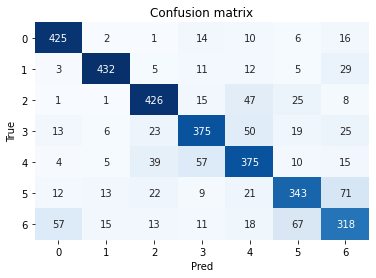

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

classes = np.unique(y_test)

cm = metrics.confusion_matrix(y_test.astype('U'), predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

## Conclusiones generales (esto estara en cada notebook):
- El modelo al precentarle una tanto noticas de tipo deportes, este por medio del f1-score, es más fiable ya que el tipo de palabras que se usan en deportes, están más en la vecindad el tipo de palabras que usa.
- En el caso de  pais tiene una exhaustividad muy alta por lo que si ve una noticia que es de la categoría país sera verdadero, pero tiene menor precisión en que precice muchas falsas noticias de otras categorías, ya que en esta categoria comparte muchas palabras de otras categorías como de tecnologicas, economia y mundo. Por la razon que si bien las noticias son muy parecidas, y que el factor diferenciador sería el nombre de los lugares, o que se habla del pais pero no necesariamente se deba incluir en esta categoría.
- El modelo que tiene un peor rango es del mundo ya que es el que en tematicos(sin considerar los lugares), puede como se dijo en el punto anterior, es el que mas comparte tematicas y palabras con el restro.
- El mejor accuary es el que usa el multinomialNB, teniendo la mayor precición, de los modelos.
- Siendo el factor más de prejuicio jugando al favor del modelo, ya que este va mejorando las probabilidades que con ciertas caracteristicas de las noticias.
- Y el peor modelo que es el k vecinos, debido a que no es muy sencible, al identificar aspectos escenciales que definen la categoria de una noticia.